# Max-P regionalization: Scalable Max-P regionalization and Enriched Max-P regionalization
**Authors:Yunfan Kang**

The `max-p regions` problem involves clustering a set of geographic areas into the maximum number of homogeneous regions that satisfies a set of user defined constraints. This notebook demonstrates the unified `maxp` API for the scalable max-p regionalizatoin (SMP) ([Alrashid, Liu, Magdy(2022)](https://doi.org/10.1145/3557915.3561011)) and the expressive max-p regionalization (EMP)([Kang and Magdy (2021)](https://ieeexplore.ieee.org/abstract/document/9835457)). 

SMP takes the same inputas the original `max-p` regions ([Duque, Anselin, Rey (2012)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9787.2011.00743.x)) problem, but provides better scalability. EMP formulation supports 5 aggregates: MIN, MAX, AVG, SUM, and COUNT. Each aggregate can be paired with a range operator and each query can contain any subset of the five aggregates.

In [1]:
import pyneapple.regionalization.maxp as maxp
import pyneapple.weight.rook as rook
import libpysal 
import time
from libpysal.weights import Queen, Rook, KNN, Kernel, DistanceBand
import numpy as np
import geopandas
import pandas
import matplotlib.pyplot as plt
import jpype
from jpype import java
from jpype import javax
import math

Because `pyneapple` is a Java-based library, to make use of the functions a JVM has been initiated when `pyneapple` is imported.

To demonstrate `max-p-enriched`, we combine the census tracts of the Los Angeles City with facts about population and employment status. The plot below shows the dataset with the areas colored by its population in 2010.

<Axes: >

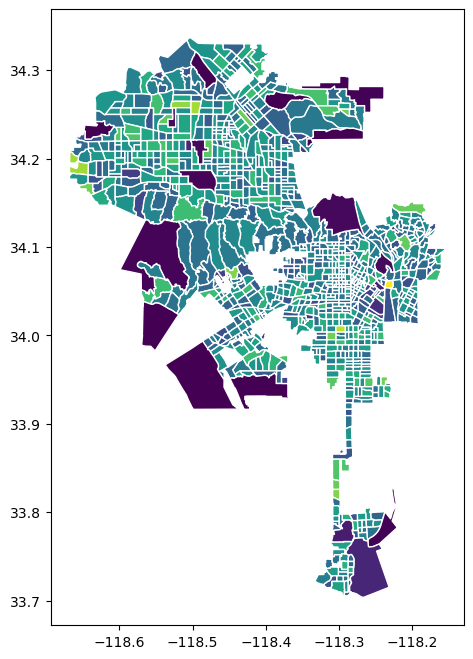

In [2]:
path = "data/LACity/LACity.shp"
lacity = geopandas.read_file(path)
lacity.plot(column = 'pop2010', figsize = (12, 8), edgecolor = 'w')

To demonstrated the capability of supporting multiple constraints with different aggregations for the EMP, the dataset is joined with the data about the population and the employment status:

In [3]:
lacity.head()

,fid,OBJECTID,TRACTCE10,POP,LATPOP_D,WHIPOP_D,BLAPOP_D,AMIPOP_D,ASIPOP_D,HPIPOP_D,...,Tot_Housin,Occup_Hous,Vac_Housin,GEO.id,pop2010,households,pop_16up,employed,unemployed,geometry
0,1.0,1,101110,4731,1324,2656,83,24,580,15,...,1734.0,1641.0,93.0,1400000US06037101110,5017,1693,3954,2512,175,"POLYGON ((-118.29420 34.26289, -118.29331 34.2..."
1,2.0,2,101122,3664,575,2437,34,18,578,3,...,1369.0,1325.0,44.0,1400000US06037101122,3663,1304,3042,1932,102,"POLYGON ((-118.28996 34.27813, -118.29006 34.2..."
2,3.0,3,101210,5990,2219,2890,192,16,625,16,...,2317.0,2150.0,167.0,1400000US06037101210,6799,2175,5370,3317,307,"POLYGON ((-118.29212 34.25071, -118.29219 34.2..."
3,4.0,4,101220,3363,1272,1662,45,25,335,6,...,1317.0,1246.0,71.0,1400000US06037101220,3189,1173,2631,1620,153,"POLYGON ((-118.27946 34.24757, -118.27976 34.2..."
4,5.0,5,101300,4199,503,3190,47,26,402,10,...,1582.0,1542.0,40.0,1400000US06037101300,3808,1408,3209,1857,151,"POLYGON ((-118.26542 34.25547, -118.26542 34.2..."


The following steps shows how the `maxp` API can be called in general.

To formulate a `max-p-enriched` problem, a number of parameters need to be specified.

Firstly, a [spatial weights object](https://pysal.org/libpysal/tutorial.html) needs to be calculated. The Pineapple package provides a module `Pineapple.weight.rook` that is supposed to give the same result as the `libpysal.weights.Rook` but runs faster espicially when the number of areas is large.

In [4]:
w = rook.from_dataframe(lacity)

1012


Then, we can formulate the query by specifying the constraints and the dissimilarity attribute. 

For the first example query, we show how a `max-p` query is formulated. We use the model to aggregate the cencus tracts in Los Angeles city into regions with population >= 200000 and the heterogeneity mesured by the number of households in each area is minimized.

In [5]:
sum_attr = 'pop2010'
sum_low = 200000.0
dis_attr = 'households'

We then pass the parameters to the module `Pineapple.regionalization.maxp`. Since only the parameters that is required for the original max-p regions problem are provided, the `SMP` module will be envolked to answer this query.

In [6]:
non_attr = 'pop_16up'
inf = java.lang.Double.POSITIVE_INFINITY
p, regions = maxp.maxp(lacity, w, dis_attr, sumName = sum_attr, sumLow = sum_low) 

The number of regions, i.e. the p value, and the region label of each area is returned after the regionalization computation.

In [7]:
p

13

In [8]:
regions

[10,
 10,
 10,
 10,
 10,
 10,
 6,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 6,
 10,
 10,
 10,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 10,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 9,
 6,
 6,
 9,
 9,
 6,
 6,
 6,
 6,
 6,
 9,
 9,
 6,
 9,
 9,
 6,
 6,
 9,
 9,
 7,
 9,
 9,
 9,
 9,
 7,
 7,
 9,
 7,
 9,
 7,
 7,
 9,
 7,
 9,
 9,
 7,
 7,
 9,
 7,
 7,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 7,
 7,
 9,
 7,
 9,
 6,
 6,
 6,
 6,
 6,
 9,
 6,
 9,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 8,
 8,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 8,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 8,
 8,
 10,
 10,
 6,
 6,
 6,
 6,
 10,
 8,
 10,
 6,
 6,
 10,
 10,
 6,
 6,
 10,
 10,
 10,
 10,
 10,
 8,
 8,
 10,
 10,
 10,
 10,
 8,
 10,
 8,
 10,
 10,
 10,
 10,
 8,
 10,
 8,
 8,
 8,
 10,
 8,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 8,
 8,
 10,
 10,
 10,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 2,
 8,
 10,
 10,
 8,
 8,
 8,
 8,
 6,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 9,
 9,
 8,
 10,
 8,
 8,
 8,

<Axes: >

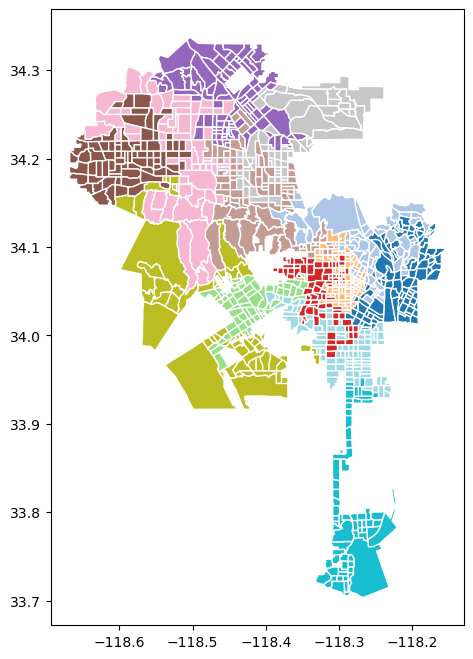

In [9]:
lacity["regionLabel"] = regions
lacity.plot(column = "regionLabel", cmap="tab20", edgecolor="w", figsize = (12, 8))

Next, we forlulate a query with multiple constraints: aggregate the cencus tracts in Los Angeles city into regions with `population >= 20000`, the minimum `labor force per area <= 3000`, average `employed population between 1500 and 3500`, and the heterogeneity mesured by the number of households in each area is minimized.
Similar to the previous example, we just need to specify the attribute for each constraint and the coresponding range. In this time, because there are multiple constraints, the `maxp` API will return the result computed by the EMP algorithm.

In [10]:
min_attr = 'pop_16up'
min_high = 3000.0
avg_attr = 'employed'
avg_low = 1000.0
avg_high = 4000.0
sum_attr = 'pop2010'
sum_low = 20000.0
dis_attr = 'households'

In [11]:
non_attr = 'pop_16up'
inf = java.lang.Double.POSITIVE_INFINITY
p, regions = maxp.maxp(lacity, w, dis_attr, minName = min_attr, minHigh = min_high, avgName = avg_attr, avgLow = avg_low, avgHigh = avg_high, sumName = sum_attr, sumLow = sum_low)

135


In [12]:
p

135

In [13]:
regions

array([  1,   3,   3, ..., 686, 706, 666], dtype=int32)

<Axes: >

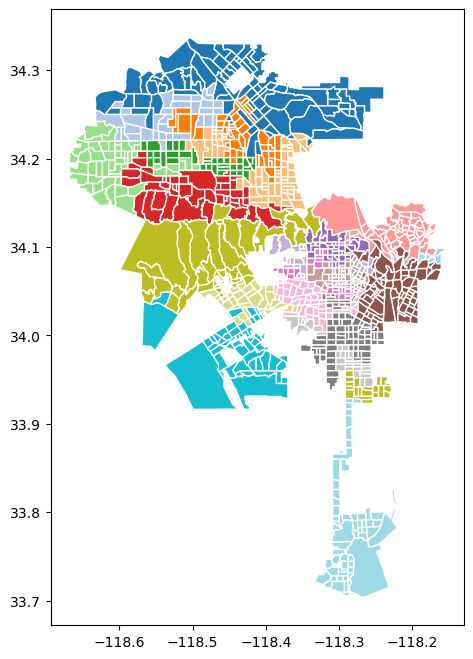

In [14]:
lacity["regionLabel"] = regions
lacity.plot(column = "regionLabel", cmap="tab20", edgecolor="w", figsize = (12, 8))